# Machine-Learning

### Recommendations: Linear Reg, DTRegression, NeuralNetwork, SVM, LogisticReg

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # Random Split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn import set_config
set_config(transform_output="pandas") # Keeps feature names after pipeline

In [2]:
def calculate_score(y_true, y_pred):
    print(f"R2 Score {r2_score(y_true, y_pred)}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred))}")

def plot(y_true, y_pred):
    f, axes = plt.subplots(1,1, figsize=(24,12))

    axes.scatter(y_true,y_pred,color = "green")
    axes.plot(y_true, y_true, 'b-', linewidth = 1)

In [3]:
df = pd.read_csv('data/clean_listing.csv')
df.head()

,Unnamed: 0,host_response_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,...,Private entrance,Host greets you,Crib,Breakfast,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,0,0.9,Tampines,East Region,1.34754,103.95958,House,Private room,1,1.0,...,True,False,False,False,12,0.842953,0.180102,7.976199,3.515767,0.785094
1,1,0.9,Tampines,East Region,1.34531,103.96100,House,Private room,2,1.0,...,False,False,False,False,12,0.880282,0.205346,7.952045,3.786036,0.502588
2,2,1.0,Bukit Merah,Central Region,1.29015,103.80814,Apartment,Private room,1,1.0,...,False,False,False,False,12,0.549557,0.117975,4.230675,1.095807,0.169376
3,3,1.0,Bukit Merah,Central Region,1.28836,103.81144,Apartment,Private room,1,1.0,...,False,False,False,False,12,0.609339,0.040906,3.862544,0.685090,0.208523
4,4,0.9,Tampines,East Region,1.34490,103.95979,House,Private room,4,3.0,...,True,False,False,False,12,0.738518,0.210803,7.816646,3.809634,0.506811


In [4]:
print(f"The standard deviation of price of listing is ${df['price'].std():.2f}.")

The standard deviation of price of listing is $132.36.


In [5]:
# Split data
Y = df['price']
X = df.drop(['price', 'Unnamed: 0'], axis=1)

In [6]:
col = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']
X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=45)

In [7]:
X.head()

,host_response_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,...,Private entrance,Host greets you,Crib,Breakfast,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,0.9,Tampines,East Region,1.34754,103.95958,House,Private room,1,1.0,1.0,...,True,False,False,False,12,0.842953,0.180102,7.976199,3.515767,0.785094
1,0.9,Tampines,East Region,1.34531,103.96100,House,Private room,2,1.0,2.0,...,False,False,False,False,12,0.880282,0.205346,7.952045,3.786036,0.502588
2,1.0,Bukit Merah,Central Region,1.29015,103.80814,Apartment,Private room,1,1.0,1.0,...,False,False,False,False,12,0.549557,0.117975,4.230675,1.095807,0.169376
3,1.0,Bukit Merah,Central Region,1.28836,103.81144,Apartment,Private room,1,1.0,1.0,...,False,False,False,False,12,0.609339,0.040906,3.862544,0.685090,0.208523
4,0.9,Tampines,East Region,1.34490,103.95979,House,Private room,4,3.0,5.0,...,True,False,False,False,12,0.738518,0.210803,7.816646,3.809634,0.506811


### Model 1: Linear Regression

Train
 Score: 0.6154558972338322
R2 Score 0.6154558972338322
RMSE : 82.48818543310342
Test
 Score: 0.6099153037191489
R2 Score 0.6099153037191489
RMSE : 80.92959334156876


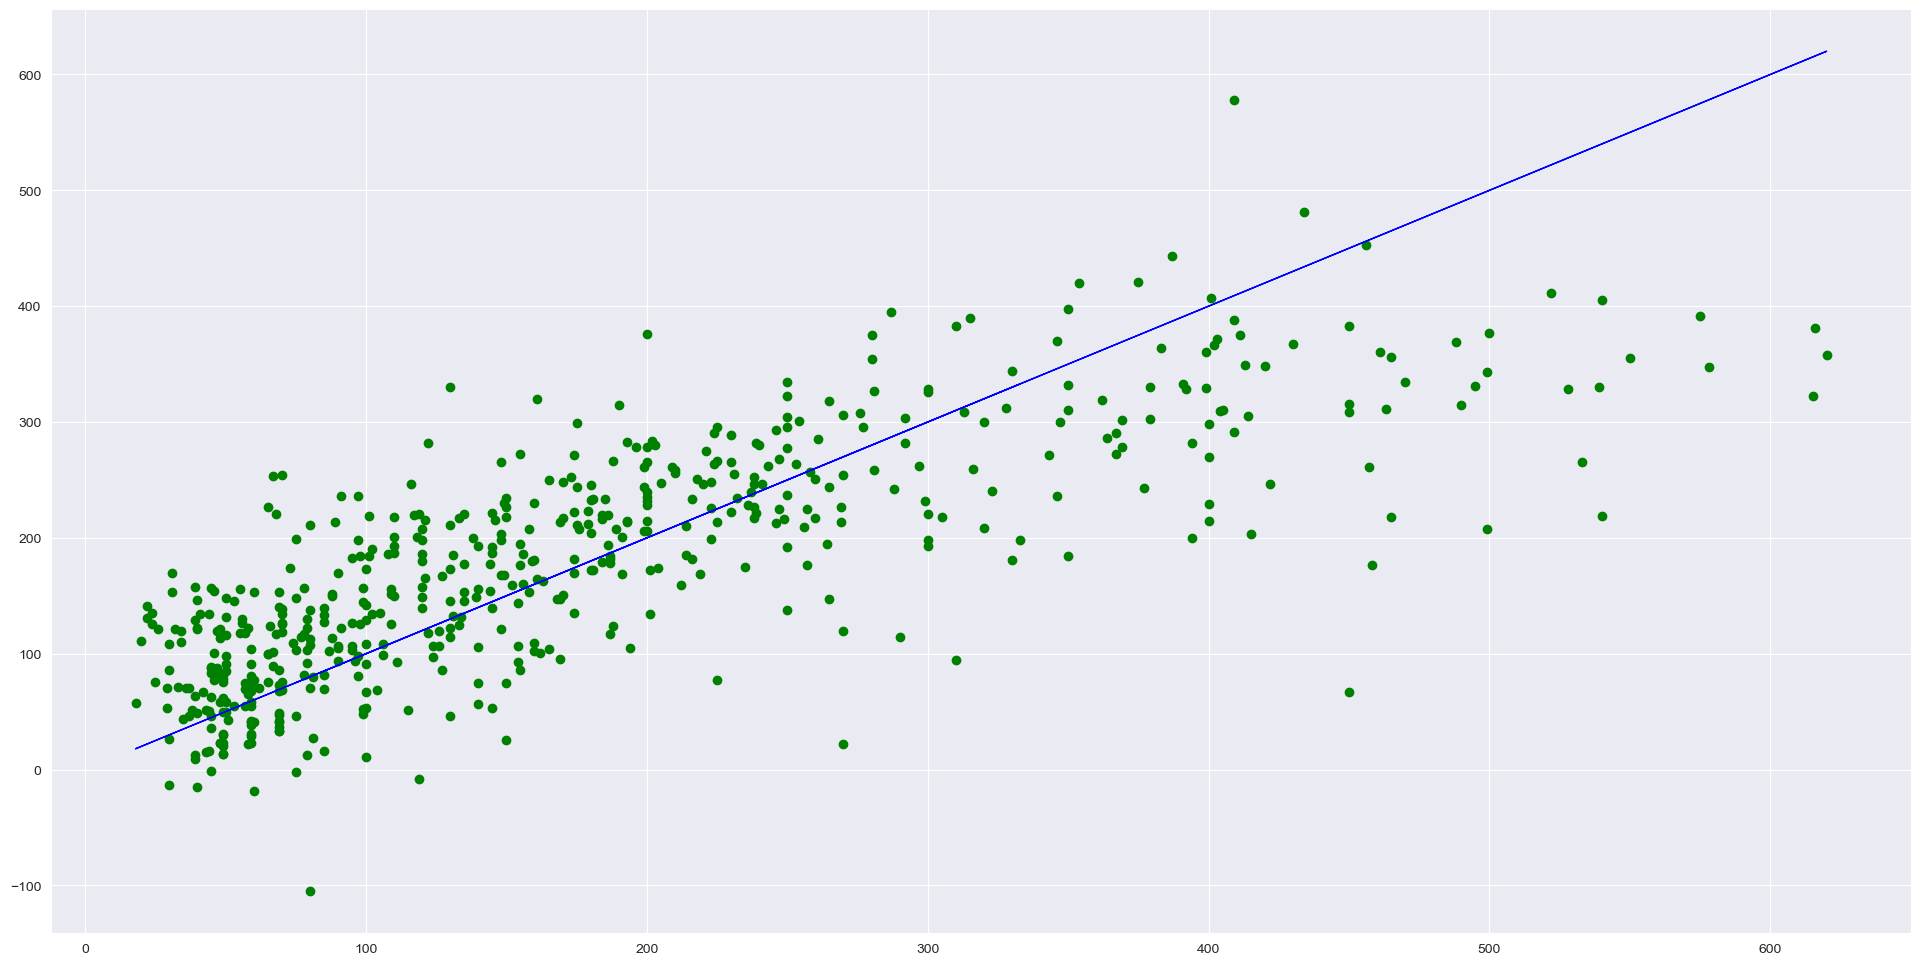

In [8]:
from sklearn.linear_model import LinearRegression

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

pipeline = make_pipeline(
    one_hot_encoder, LinearRegression()
)

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)

print(f"Train\n Score: {pipeline.score(X_train, y_train)}")
calculate_score(y_train, y_train_pred)

print(f"Test\n Score: {pipeline.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

plot(y_test, y_pred)

### Model 2: Gradient Boost Regressor

Train
Score: 0.9509337382209563
R2 Score 0.9509337382209563
RMSE : 29.46525189271713
Test
Score: 0.7638124570373299
R2 Score 0.7638124570373299
RMSE : 62.97329183865414


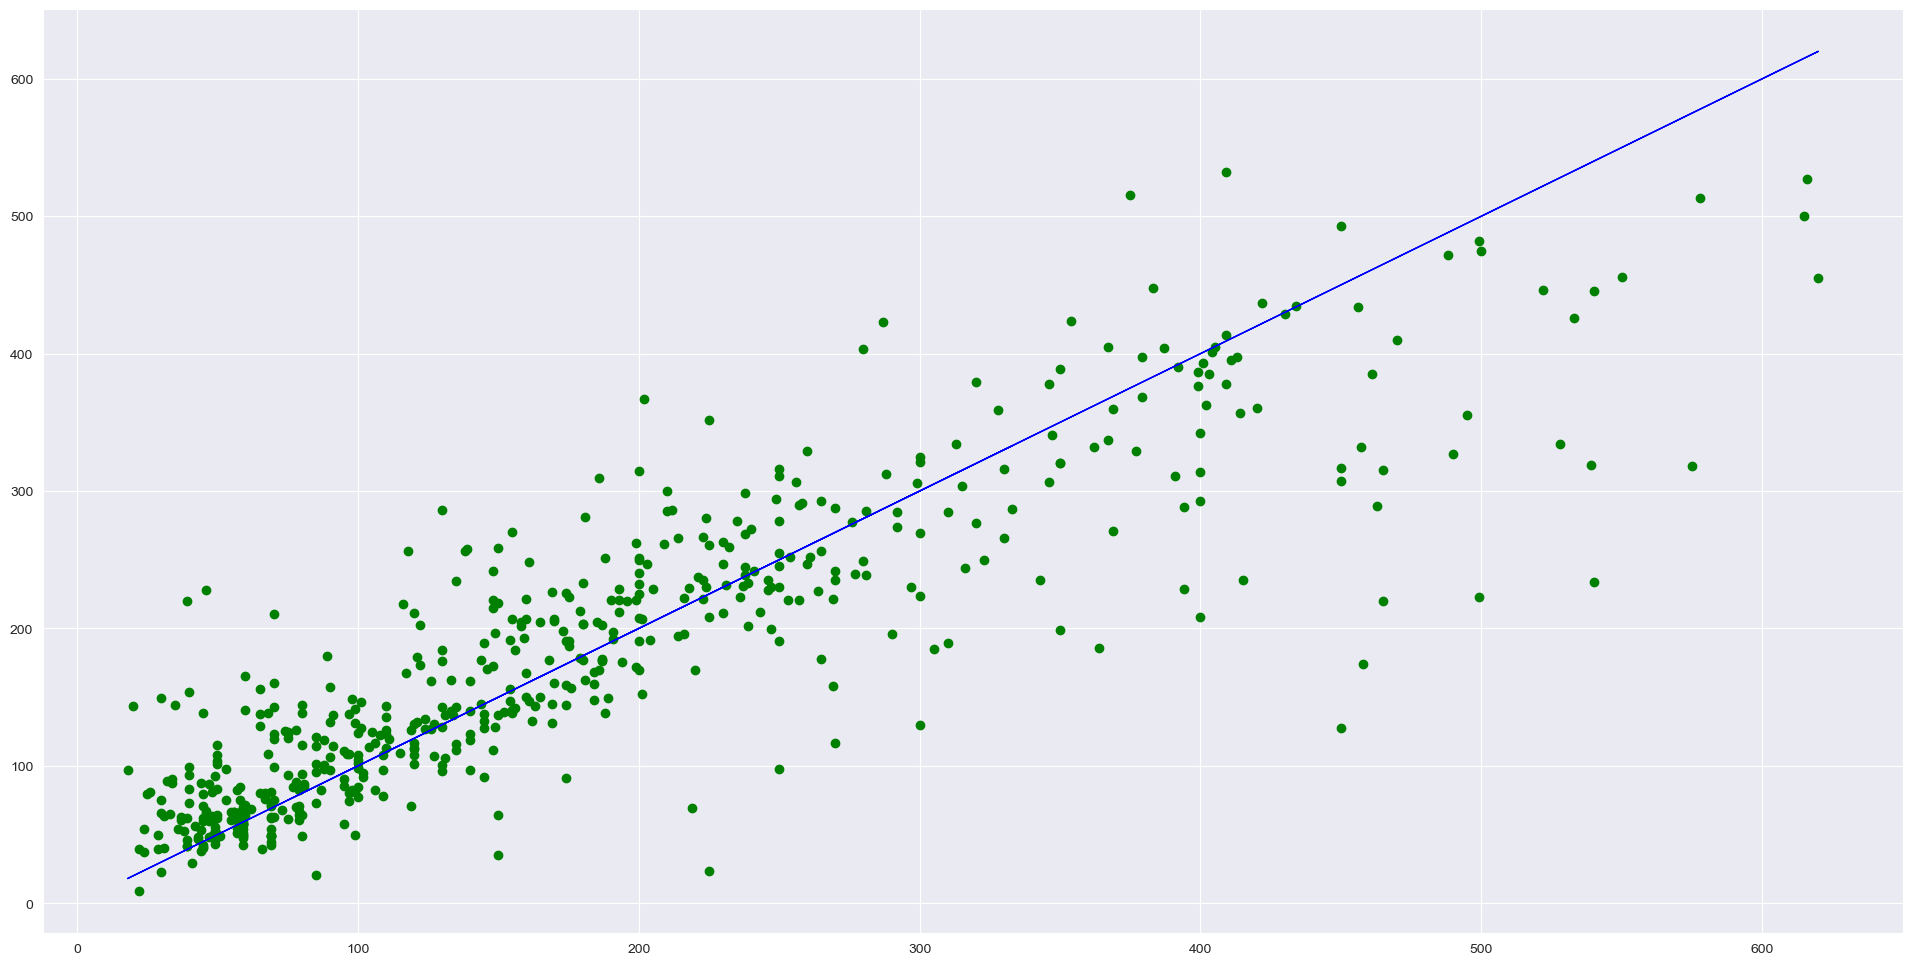

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor

pipeline = make_pipeline(
    one_hot_encoder, HistGradientBoostingRegressor()
)
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)

print(f"Train\nScore: {pipeline.score(X_train, y_train)}")
calculate_score(y_train, y_train_pred)

print(f"Test\nScore: {pipeline.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

plot(y_test, y_pred)

### Model 3: XGBoost Regression

We can use gradient boosting - a type of ensemble machine learning algorithms. Ensemble is a collection of decision trees. Every iteration, a decision tree is added to model to minimise the error. Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm, and the goal is to minimise loss gradient. We will use XGBoost API to do the model fitting.

Train
Score:1.0
R2 Score 0.9920725756570241
RMSE : 11.843627107874417
Test
Score:0.7635966503848004
R2 Score 0.7635966503848004
RMSE : 63.002054897490666


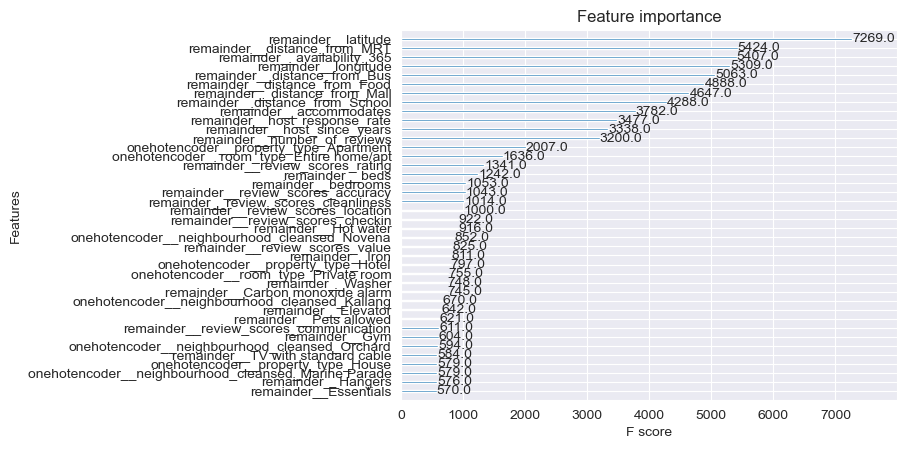

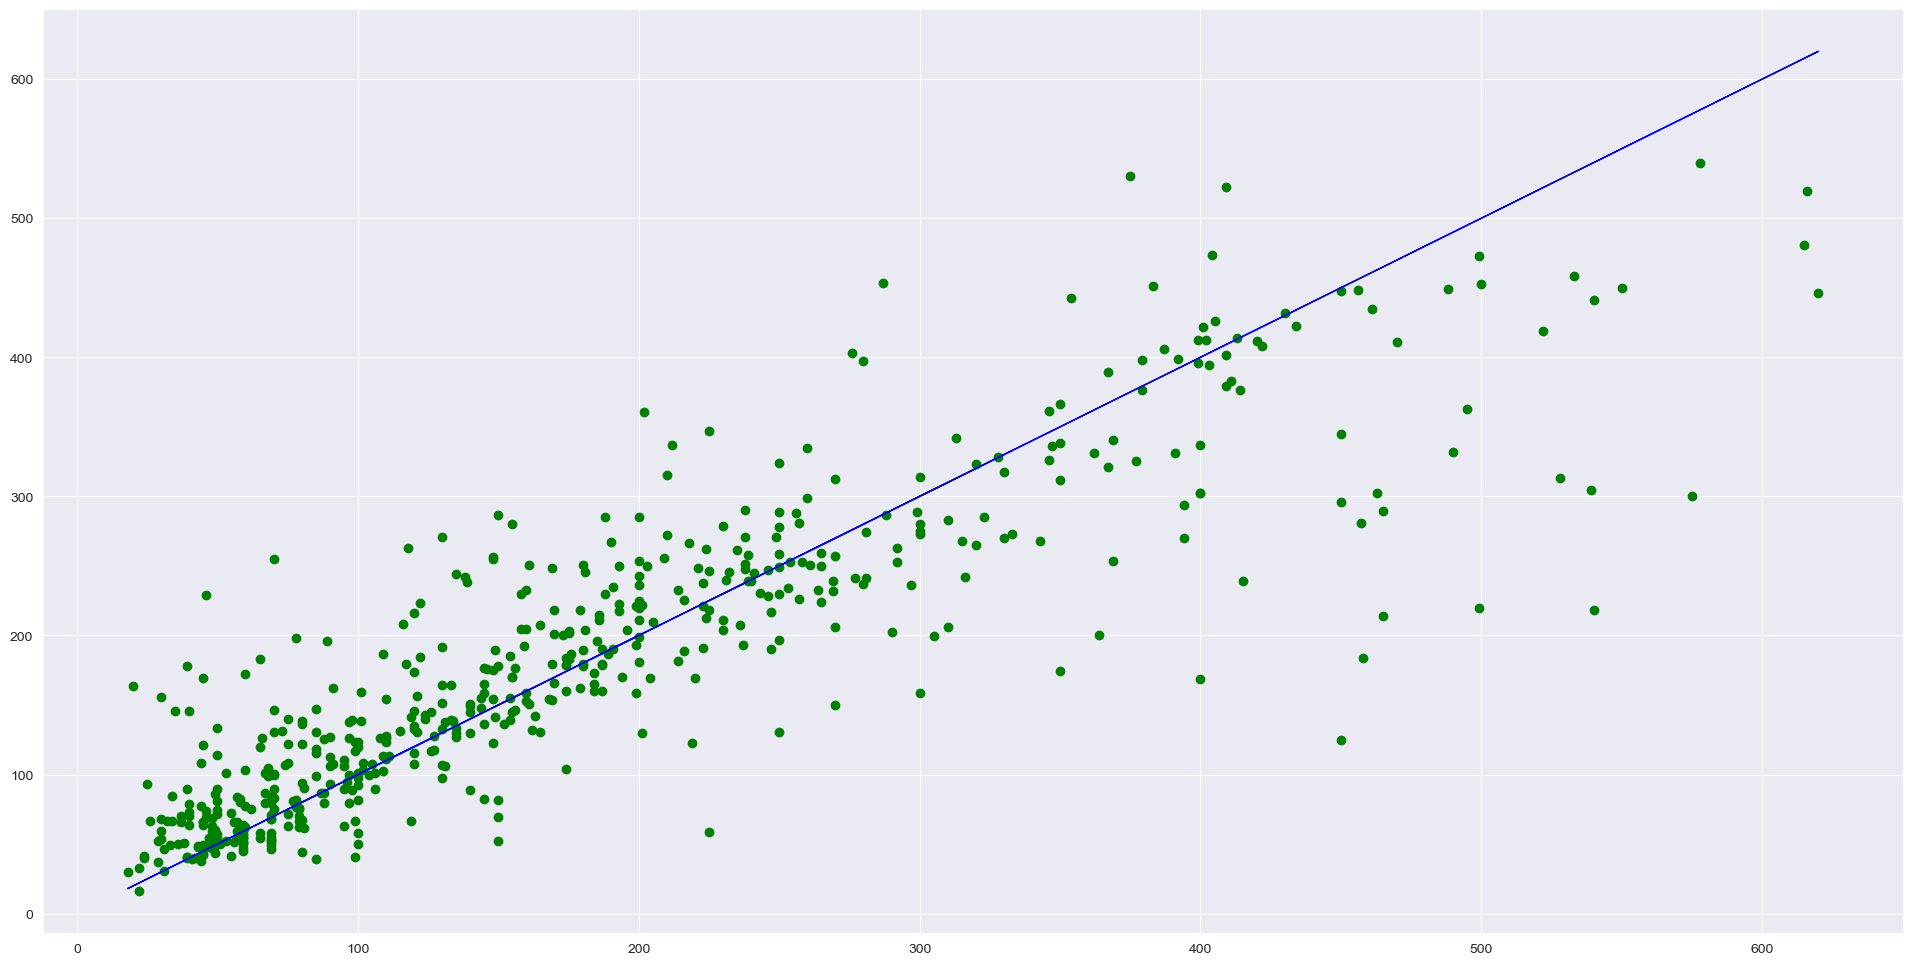

In [10]:
import xgboost as xgb
import graphviz

model = xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror', n_estimators = 2500,
                         learning_rate=0.01)

pipeline = Pipeline([
    ('ohe', one_hot_encoder),
    ('model', model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

print(f"Train\nScore:{pipeline.score(X_train, y_train_pred)}")
calculate_score(y_train, y_train_pred)

print(f"Test\nScore:{pipeline.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

xgb.plot_importance(model.get_booster(), max_num_features=40)

plot(y_test, y_pred)

We can conclude that:... .